# Assignment 2: Likelihood free inference

<span style="font-size:18px;">

The goal of likelihood-free methods, also known as simulation-based inference (SBI), is to enable statistical inference in cases where calculating the likelihood function directly is impractical or intractable. This approach is particularly useful when the system being studied is complex, and the underlying process generating the data can be simulated, but deriving an explicit likelihood function is difficult or impossible.
    
In the following we set up a simple toy problem to test the functionality of likelihood-free methods. 

$\theta \sim \mathcal{N}(\theta; \mu=0, \sigma=3) \qquad  x_1 \sim \mathcal{N}(x_1; \mu=2\cdot\sin(\theta), \sigma=0.5)  \qquad x_2 \sim \mathcal{N}(x_2; \mu=0.1\cdot \theta^2,  \sigma=(0.5\cdot |x_1|))$

In the following we will look into the `Python` package `sbi` which is a library for likelihood-free inference. We will generate data from the model defined above and then use the `sbi` package to perform inference on the model.
    
</span>

In [1]:
!pip install sbi


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
# Make sure to have sbi installed (https://sbi-dev.github.io/sbi/v0.23.2/)
from sbi.analysis import pairplot
import torch
from sbi.inference import SNPE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def generate_data(n:int):
    """Generate data from the model defined above"""
    # Prior on a parameter
    theta = np.random.normal(size=n) * 3 
    # Data generated, x1, from the parameter given the model stated above
    x1 = 2*np.sin(theta) + np.random.normal(size=n) * 0.5
    # The data points in the x2 variable depend on theta and the latent variable x1
    x2 = 0.1*theta**2 + 0.5*np.abs(x1)*np.random.normal(size=n)
    # Return sample from the joint 
    return np.vstack([theta, x1, x2]).T

# We sample from the data and plot the joint distribution of the variables

In [4]:
data = generate_data(10_000)  # Shape: (n, nodes, dim) here dim = 1

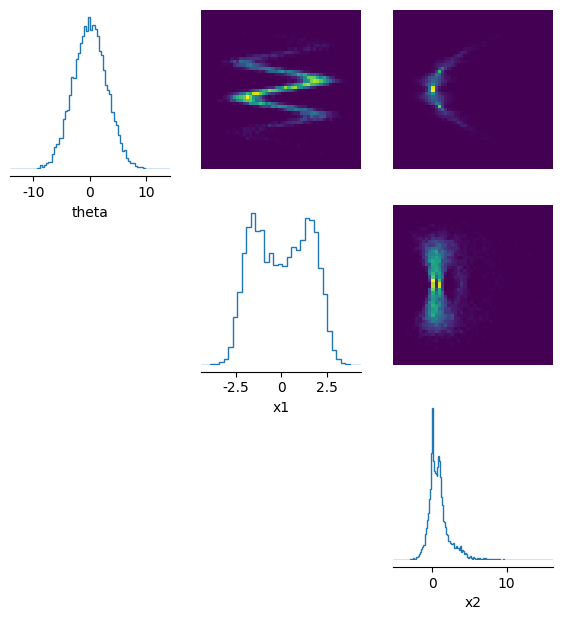

In [5]:
_ = pairplot(data, labels=["theta", "x1", "x2"], figsize=(7,7))

## Exercise 1 (6 points): Use sbi to perform inference on the model defined above
<span style="font-size:18px;">

Use neural posterior estimation (NPE) to perform inference on the model defined above. The goal is to infer the posterior distribution of the parameter $\theta$ given the data $x_1$ and $x_2$. Use the `sbi` package to perform the inference. Explain the steps you took to perform the inference and the results you obtained. Plot the posterior distribution of the parameter $\theta$ for a given set of data points $x_1$ and $x_2$ (use concrete values for $x_1$ and $x_2$).
    
</span>

In [6]:
def NPE(theta_samples, x_samples):
    # defining the prior
    prior = torch.distributions.Normal(loc=0.0, scale=3.0)
    # the inference method - NPE
    inference = SNPE(prior=prior)
    # training the NPE on generated samples
    inference.append_simulations(theta_samples, x_samples).train()
    # building the posterior
    posterior = inference.build_posterior()

    return posterior

# splitting training data
theta_samples = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(-1)
x_samples = torch.tensor(data[:, 1:], dtype=torch.float32)

# training the posterior
posterior = NPE(theta_samples, x_samples)


c:\SpecProF\Python\lib\site-packages\sbi\neural_nets\net_builders\flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 151 epochs.

In [7]:
# Use multiple observations of x1 and x2
x_1_observed_value = 1.5
x_2_observed_value = 0.8
observed_x = torch.tensor([[x_1_observed_value, x_2_observed_value]])

n_samples = 1000

# obtain the sampless
samples = posterior.sample((n_samples,), x=observed_x)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

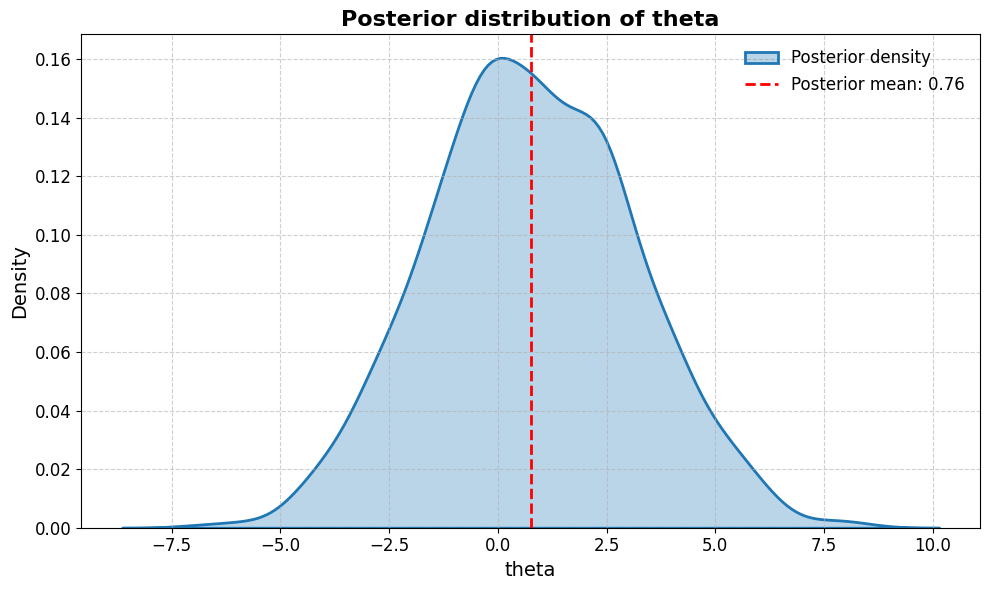

In [8]:
# plotting
plt.figure(figsize=(10, 6))
sns.kdeplot(samples.numpy(), color='black', fill=True, alpha=0.3, linewidth=2, label='Posterior density')
posterior_mean = np.mean(samples.numpy())
plt.axvline(posterior_mean, color='red', linestyle='--', linewidth=2, label=f'Posterior mean: {posterior_mean:.2f}')
plt.title('Posterior distribution of theta', fontsize=16, weight='bold', color='black')
plt.xlabel('theta', fontsize=14, color='black')
plt.ylabel('Density', fontsize=14, color='black')
plt.xticks(fontsize=12, color='black')
plt.yticks(fontsize=12, color='black')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12, frameon=False, facecolor='white')
plt.tight_layout()
plt.show()


## Results

- This histogram represents the posterior distribution of the parameter theta after performing inference with the observed data and it shows the updated belief about possible theta values. We can see that theta has a distribution centered around approximately 1 (the posterior mean is 0.76) and is spread between -7.5 and 10.

- It has also learned the posterior distribution well after **151 epochs**.

# Exercise 2 (3 points): Missing values handling in SBI

<span style="font-size:18px;">

In the model defined above, we have two observed variables $x_1$ and $x_2$ and one parameter $\theta$. In practice, we might have missing values in the data. Traditional `sbi` methods cannot handle missing values in the data. In the following, randomly set some values (e.g., ~30%) in the data to `np.nan` (only in $x_1$ and $x_2$) and then use one simple and one more sophisticated imputation strategy to impute the missing data. Use an appropriate plot to display the data alongside the missing data (make sure to still show the available data). Also plot the imputed data sets and compare them visually. Explain the imputation strategies you used and the results you obtained.

</span> 

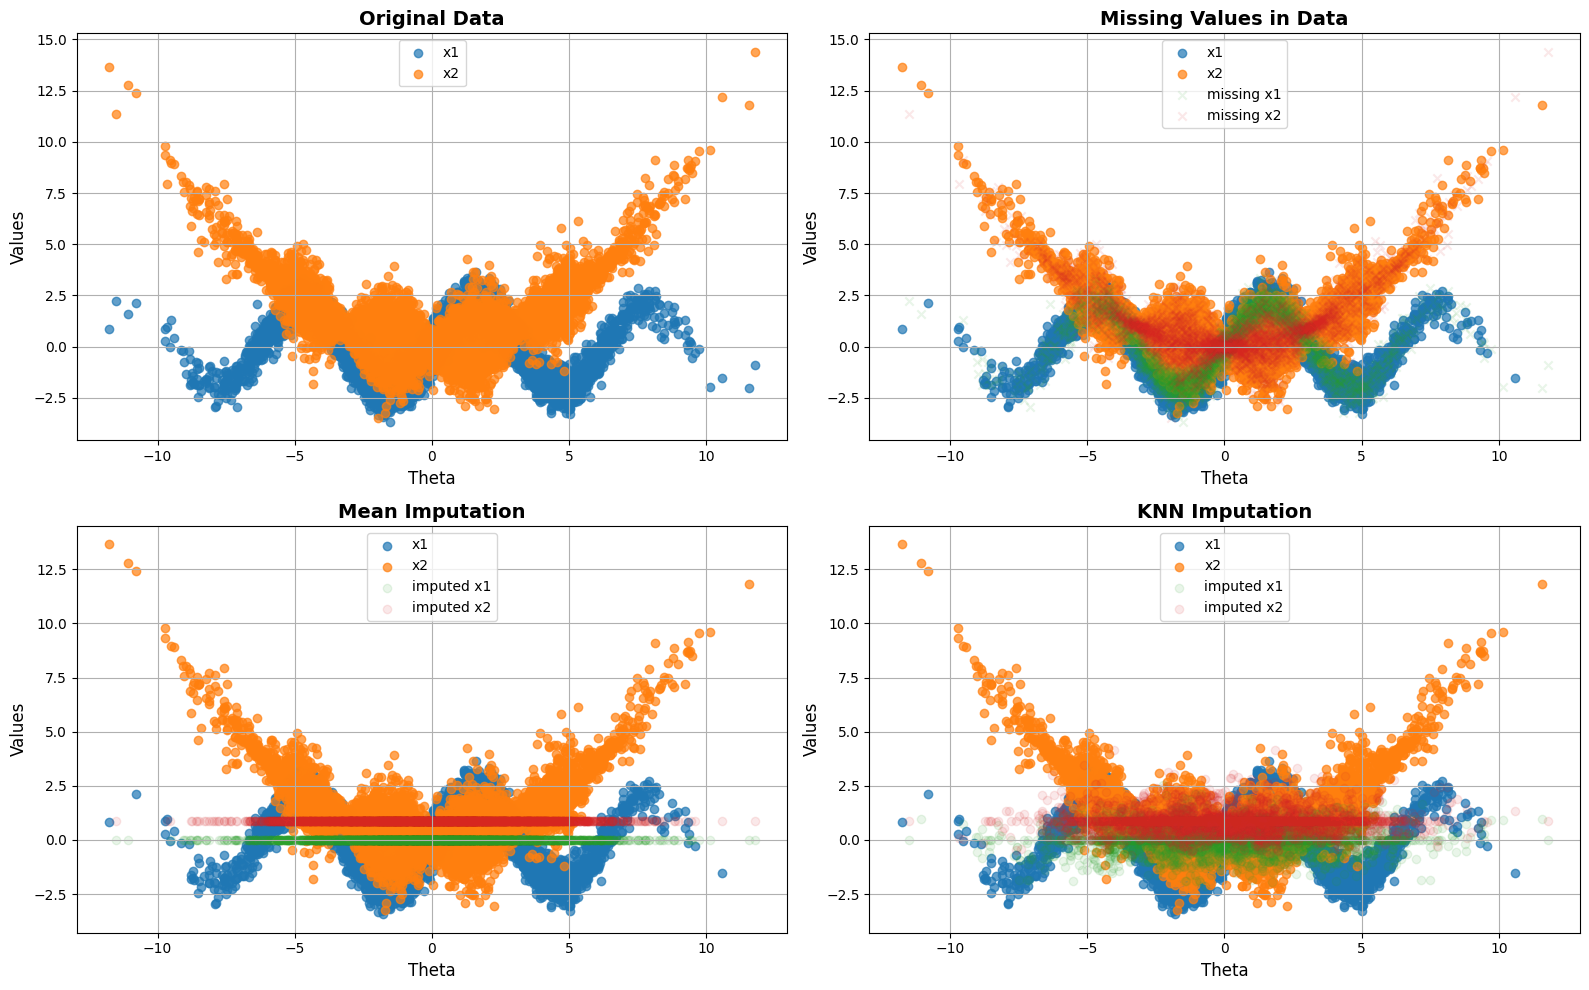

In [9]:
# obtaining the data
theta = data[:, 0]
x1 = data[:, 1]
x2 = data[:, 2]

n = len(data)

knn_neighbors = 5

# setting 30% data to missing (NaN)
missing_mask_x1 = np.random.rand(n) < 0.3
missing_mask_x2 = np.random.rand(n) < 0.3
x1_missing = x1.copy()
x2_missing = x2.copy()
x1_missing[missing_mask_x1] = np.nan
x2_missing[missing_mask_x2] = np.nan

# first imputation technique - replace missing values with mean
simple_imputer = SimpleImputer(strategy='mean')
x1_imputed_simple = simple_imputer.fit_transform(x1_missing.reshape(-1, 1)).flatten()
x2_imputed_simple = simple_imputer.fit_transform(x2_missing.reshape(-1, 1)).flatten()

# second imputation technique - kNN
knn_imputer = KNNImputer(n_neighbors=knn_neighbors)
x1_imputed_knn, x2_imputed_knn = knn_imputer.fit_transform(np.vstack([x1_missing, x2_missing]).T).T

# plotting
plt.figure(figsize=(16, 10))

# original data
plt.subplot(2, 2, 1)
plt.scatter(theta, x1, label='x1', alpha=0.7, color='#1f77b4') 
plt.scatter(theta, x2, label='x2', alpha=0.7, color='#ff7f0e')  
plt.title("Original Data", fontsize=14, weight='bold')
plt.xlabel("Theta", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(loc='upper center')
plt.grid(True)

# missing data
plt.subplot(2, 2, 2)
plt.scatter(theta[~missing_mask_x1], x1[~missing_mask_x1], alpha=0.7, color='#1f77b4', label='x1')
plt.scatter(theta[~missing_mask_x2], x2[~missing_mask_x2], alpha=0.7, color='#ff7f0e', label='x2')
plt.scatter(theta[missing_mask_x1], x1[missing_mask_x1], alpha=0.1, color='#2ca02c', marker='x', label='missing x1')
plt.scatter(theta[missing_mask_x2], x2[missing_mask_x2], alpha=0.1, color='#d62728', marker='x', label='missing x2')
plt.title("Missing Values in Data", fontsize=14, weight='bold')
plt.xlabel("Theta", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(loc='upper center')
plt.grid(True)

# mean imputation
plt.subplot(2, 2, 3)
plt.scatter(theta[~missing_mask_x1], x1_missing[~missing_mask_x1], alpha=0.7, color='#1f77b4', label='x1')
plt.scatter(theta[~missing_mask_x2], x2_missing[~missing_mask_x2], alpha=0.7, color='#ff7f0e', label='x2')
plt.scatter(theta[missing_mask_x1], x1_imputed_simple[missing_mask_x1], alpha=0.1, color='#2ca02c', label='imputed x1')
plt.scatter(theta[missing_mask_x2], x2_imputed_simple[missing_mask_x2], alpha=0.1, color='#d62728', label='imputed x2')
plt.title("Mean Imputation", fontsize=14, weight='bold')
plt.xlabel("Theta", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(loc='upper center')
plt.grid(True)

# KNN imputation 
plt.subplot(2, 2, 4)
plt.scatter(theta[~missing_mask_x1], x1_missing[~missing_mask_x1], alpha=0.7, color='#1f77b4', label='x1')
plt.scatter(theta[~missing_mask_x2], x2_missing[~missing_mask_x2], alpha=0.7, color='#ff7f0e', label='x2')
plt.scatter(theta[missing_mask_x1], x1_imputed_knn[missing_mask_x1], alpha=0.1, color='#2ca02c', label='imputed x1')
plt.scatter(theta[missing_mask_x2], x2_imputed_knn[missing_mask_x2], alpha=0.1, color='#d62728', label='imputed x2')
plt.title("KNN Imputation", fontsize=14, weight='bold')
plt.xlabel("Theta", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(loc='upper center')
plt.grid(True)

plt.tight_layout()
plt.show()

## Imputation results
- The first technique of imputation is just replacing the missing value with the **mean value** of the feature, so all imputated points **lie on the same line** as you can see from the third plot (one line for x1, one line for x2). 

- For the second imputating technique, I used **kNN**, where the mean of k nearest neighbouring entries from the missing value is taken to replace the missing value. I have decided to compare it to 5 nearest neighbours, and the results are far better than in the first example, where our fourth plot looks so much more as the first one in comparison to the mean imputation plot.

# Exercise 3 (3 points): Run SBI on the imputed data

<span style="font-size:18px;">

Use the imputed data sets from the previous exercise and run the NPE method from `sbi` on the imputed data. Compare the results with the results from the previous exercise. Explain the differences in the results and the implications of using imputed data for likelihood-free inference.

</span>


In [10]:
# get the posteriors
x_samples_imputed_simple = np.vstack([x1_imputed_simple, x2_imputed_simple]).T
x_samples_imputed_simple = torch.tensor(x_samples_imputed_simple, dtype=torch.float32)
posterior_imputed_simple = NPE(theta_samples, x_samples_imputed_simple)

x_samples_knn = np.vstack([x1_imputed_knn, x2_imputed_knn]).T
x_samples_knn = torch.tensor(x_samples_knn, dtype=torch.float32)
posterior_knn = NPE(theta_samples, x_samples_knn)

c:\SpecProF\Python\lib\site-packages\sbi\neural_nets\net_builders\flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 65 epochs.

In [11]:
# get the samples
samples_imputed_simple = posterior_imputed_simple.sample((1000,), x=observed_x)

samples_knn = posterior_knn.sample((1000,), x=observed_x)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

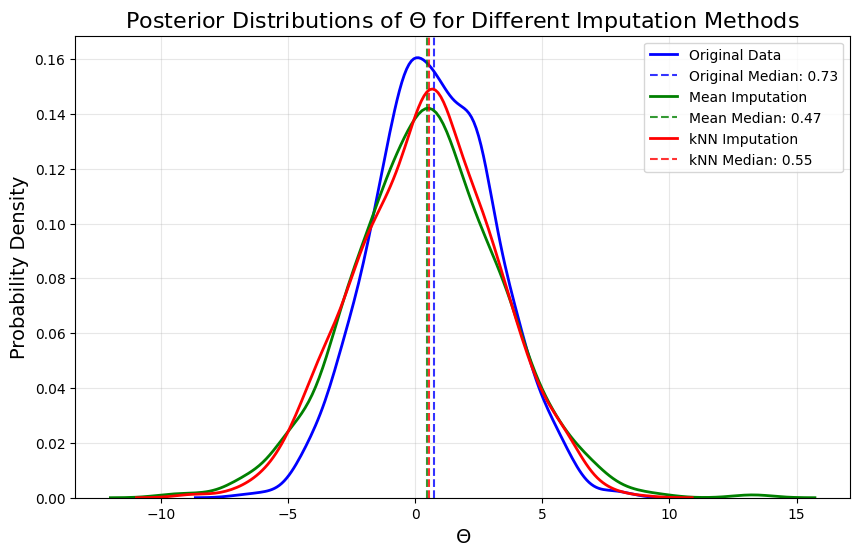

In [12]:
# plotting
plt.figure(figsize=(10, 6))

# original 
sns.kdeplot(samples.numpy().flatten(), label='Original Data', color='blue', linewidth=2, fill=False)
median_original = np.median(samples.numpy().flatten())
plt.axvline(median_original, color='blue', linestyle='--', alpha=0.8, label=f'Original Median: {median_original:.2f}')

# mean imputation
sns.kdeplot(samples_imputed_simple.numpy().flatten(), label='Mean Imputation', color='green', linewidth=2, fill=False)
median_mean = np.median(samples_imputed_simple.numpy().flatten())
plt.axvline(median_mean, color='green', linestyle='--', alpha=0.8, label=f'Mean Median: {median_mean:.2f}')

# kNN imputation
sns.kdeplot(samples_knn.numpy().flatten(), label='kNN Imputation', color='red', linewidth=2, fill=False)
median_knn = np.median(samples_knn.numpy().flatten())
plt.axvline(median_knn, color='red', linestyle='--', alpha=0.8, label=f'kNN Median: {median_knn:.2f}')

plt.title("Posterior Distributions of $\\Theta$ for Different Imputation Methods", fontsize=16)
plt.xlabel("$\\Theta$", fontsize=14)
plt.ylabel("Probability Density", fontsize=14)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3)
plt.show()


## Differences in the Results

- **Original Posterior:**
  - The posterior is centered near 1, but skewed to the left, median is 0.73, reflecting the true underlying relationship between theta and the observed data (x_1, x_2).
  - This is expected as the original data contains no missing values, preserving the full distributional information for inference.

- **Mean-Imputed Posterior:**
  - The posterior was smoothened out, and because of the mean imputation it got more centered around it resulting in 0.47 median value.
  - The imputation by mean introduces bias because it oversimplifies the distribution of the missing data. Missing values are replaced with the global mean, effectively reducing variability and underestimating uncertainty in the imputed data.

- **kNN-Imputed Posterior:**
  - The posterior here also differs from the original, but it appears to better align with the original's tendency (median at 0.55).
  - KNN imputation tends to better preserve local structures in the data by filling in missing values based on nearby samples. However, the approach still assumes certain patterns in the data and may smooth out fine details, potentially leading to slight deviations.

## Implications for Likelihood-Free Inference

- **Imputation as Approximation:**
  - Data imputation introduces approximations that can distort the statistical relationship between parameters theta and the observed data (x_1, x_2).
  - This affects the posterior, as likelihood-free inference relies on the ability to capture this relationship accurately.

- **Bias and Variance:**
  - **Mean imputation** introduces systematic bias by reducing the variance of imputed data. This can lead to overconfidence in the posterior and a shift in the posterior's location, as seen in the leftward shift.
  - **KNN imputation** preserves more local relationships and variability, leading to a posterior closer to the original. However, it still introduces slight biases due to assumptions inherent in the algorithm (e.g., nearest neighbors may not fully capture the data-generating process).

- **Uncertainty Quantification:**
  - Likelihood-free methods depend on accurately capturing uncertainty in the data. Imputation methods may underestimate or misrepresent uncertainty, leading to posteriors that are narrower or misaligned with the true posterior.

- **Choice of Imputation Method:**
  - The choice of imputation method can significantly influence results. Simple imputation methods like mean imputation are computationally efficient but introduce more bias, while more complex methods like kNN better preserve data relationships but may be more computationally intensive and dependent on parameter tuning.
